In [1]:
# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Keras / TensorFlow - Layers & Models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed

# Keras / TensorFlow - Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2025-06-25 11:06:03.888844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('/Users/antotim/Desktop/POWER_AI/data/merged_dataset.csv')
df.drop(columns=['id'], inplace=True)

# Data Split

In [3]:
df_pdu = df[[col for col in df.columns if col.startswith('pdu')] + ['data_hora']].copy()
df_pdu.columns

Index(['pdu1_i', 'pdu1_fp', 'pdu1_kwh', 'pdu2_i', 'pdu2_fp', 'pdu2_kwh',
       'pdu3_i', 'pdu3_fp', 'pdu3_kwh', 'pdu4_i', 'pdu4_fp', 'pdu4_kwh',
       'pdu5_i', 'pdu5_fp', 'pdu5_kwh', 'pdu6_i', 'pdu6_fp', 'pdu6_kwh',
       'pdu7_i', 'pdu7_fp', 'pdu7_kwh', 'pdu8_i', 'pdu8_fp', 'pdu8_kwh',
       'data_hora'],
      dtype='object')

In [4]:
def window_dataframe_pdu(df, window_size=12):
    """
    Transform PDU DataFrame into windowed format.
    Returns a DataFrame where each row is a time window of fixed size,
    and columns are named by variable and time index (e.g., pdu1_i-1, pdu1_i-2, ...).
    """
    n_rows = df.shape[0]
    n_windows = n_rows // window_size
    df_trunc = df.iloc[:n_windows * window_size]
    data = df_trunc.values.reshape(n_windows, window_size, df.shape[1])

    # Build new column names: for each variable, all window steps
    new_columns = []
    for col in df.columns:
        for i in range(window_size):
            new_columns.append(f"{col}-{i+1}")

    # Transpose axes to get all time steps for each variable together
    data_2d = data.transpose(0, 2, 1).reshape(n_windows, -1)
    return pd.DataFrame(data_2d, columns=new_columns)

# PDU_FP

In [5]:
df_pdu_fp = df_pdu[['pdu1_fp', 'pdu2_fp', 'pdu3_fp', 'pdu4_fp', 'pdu5_fp', 'pdu6_fp', 'pdu7_fp', 'pdu8_fp']].copy()

### 1. Data Preparation

In [6]:
# Parameters
window_size = 32
pdu_fp_phases = ['pdu1_fp', 'pdu2_fp', 'pdu3_fp', 'pdu4_fp', 'pdu5_fp', 'pdu6_fp', 'pdu7_fp', 'pdu8_fp']

# Windowing
df_pdu_fp_win = window_dataframe_pdu(df_pdu_fp, window_size=window_size)
df_pdu_fp_win_plot = df_pdu_fp_win.copy()

In [7]:
df_pdu_fp_win.head()

,pdu1_fp-1,pdu1_fp-2,pdu1_fp-3,pdu1_fp-4,pdu1_fp-5,pdu1_fp-6,pdu1_fp-7,pdu1_fp-8,pdu1_fp-9,pdu1_fp-10,...,pdu8_fp-23,pdu8_fp-24,pdu8_fp-25,pdu8_fp-26,pdu8_fp-27,pdu8_fp-28,pdu8_fp-29,pdu8_fp-30,pdu8_fp-31,pdu8_fp-32
0,0.83,0.83,0.83,0.83,0.83,0.82,0.83,0.83,0.83,0.83,...,0.95,0.94,0.94,0.97,0.95,0.95,0.95,0.95,0.94,0.94
1,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,...,0.95,0.95,0.95,0.95,0.96,0.94,0.92,0.95,0.95,0.94
2,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,...,0.97,0.94,0.92,0.97,0.94,0.94,0.95,0.94,0.95,0.94
3,0.83,0.83,0.83,0.83,0.83,0.82,0.83,0.83,0.83,0.83,...,0.94,0.95,0.94,0.95,0.92,0.94,0.95,0.95,0.95,0.94
4,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,...,0.95,0.94,0.94,0.94,0.95,0.94,0.94,0.95,0.94,0.94


### Compute Windows Means

In [8]:
pdu_phases = ['pdu1_fp', 'pdu2_fp', 'pdu3_fp', 'pdu4_fp', 'pdu5_fp', 'pdu6_fp', 'pdu7_fp', 'pdu8_fp']

for phase in pdu_fp_phases:
    cols = [f"{phase}-{i+1}" for i in range(window_size)]
    df_pdu_fp_win_plot[f"{phase}_mean"] = df_pdu_fp_win_plot[cols].mean(axis=1)

### Assign Timestamps

In [9]:
# Ensure df_pdu is sorted by time
df_pdu['data_hora'] = pd.to_datetime(df_pdu['data_hora'])
df_pdu = df_pdu.sort_values('data_hora')

# Assign timestamps to each window (last timestamp in each window)
timestamps = df_pdu['data_hora'].values
n_windows = len(df_pdu_fp_win_plot)
window_timestamps = [timestamps[(i+1)*window_size - 1] for i in range(n_windows)]
df_pdu_fp_win_plot['window_time'] = pd.to_datetime(window_timestamps)
df_pdu_fp_win_plot = df_pdu_fp_win_plot.set_index('window_time')

### Plot Windowed Means

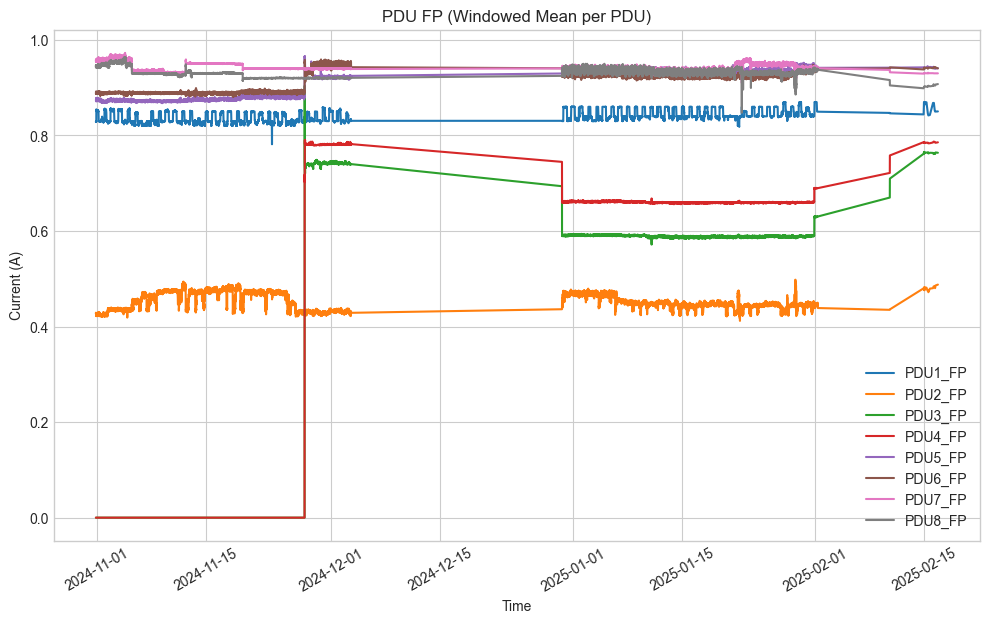

In [10]:
# Plot windowed means for PDU currents
plt.figure(figsize=(10, 6))
for phase in pdu_phases:
    plt.plot(df_pdu_fp_win_plot.index, df_pdu_fp_win_plot[f"{phase}_mean"], label=phase.upper())

plt.title("PDU FP (Windowed Mean per PDU)")
plt.xlabel("Time")
plt.ylabel("Current (A)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

### 2.Autoencoder

#### Data Split

In [11]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

# Define test period
test_start = pd.to_datetime('2024-12-29')
test_end = pd.to_datetime('2025-02-23')

In [12]:
# Split windowed data
test_mask = (df_pdu_fp_win_plot.index >= test_start) & (df_pdu_fp_win_plot.index <= test_end)
df_test_win = df_pdu_fp_win_plot[test_mask].copy()
df_train_win = df_pdu_fp_win_plot[~test_mask].copy()

# Drop mean columns for model input
X_train_win = df_train_win.drop(columns=[c for c in df_train_win.columns if c.endswith('_mean')])
X_test_win = df_test_win.drop(columns=[c for c in df_test_win.columns if c.endswith('_mean')])

#### Scaling

In [13]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_win)
X_test_scaled = scaler.transform(X_test_win)

#### Model Def & Training

In [14]:
# Build autoencoder
model_ae = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=regularizers.l2(1e-4)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(X_train_scaled.shape[1], activation='linear')
])
model_ae.compile(optimizer='adam', loss='mse')

/Users/antotim/.pyenv/versions/power_ai_clean/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
early_stop_ae = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint_ae = ModelCheckpoint("models/best_model_ae_pdu_fp.h5", monitor='val_loss', save_best_only=True)

history_ae = model_ae.fit(
    X_train_scaled, X_train_scaled,
    epochs=50,  # pareil ici
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop_ae, checkpoint_ae],
    verbose=1,
    shuffle=True
)

Epoch 1/50
200/214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4036

214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3931 - val_loss: 2.7181
Epoch 2/50
212/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1298

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1298 - val_loss: 2.6569
Epoch 3/50
199/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1263

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1261 - val_loss: 2.5854
Epoch 4/50
209/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1214

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1214 - val_loss: 2.5611
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1201 - val_loss: 2.5789
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1208 - val_loss: 2.6034
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1169 - val_loss: 2.6315
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1174 - val_loss: 2.6385
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1153 - val_loss: 2.6254
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1138 - val_loss: 2.5848
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1134 - val_loss: 2.5889


#### Anomaly Detection

In [16]:
# Predict and detect anomalies
reconstructed = model_ae.predict(X_test_scaled)
reconstruction_errors = np.mean(np.square(X_test_scaled - reconstructed), axis=1)
threshold = np.percentile(reconstruction_errors, 99.75)
anomalies = reconstruction_errors > threshold

df_test_win['reconstruction_error_ae'] = reconstruction_errors
df_test_win['predicted_label_ae'] = anomalies.astype(int)

260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


#### Plot Results

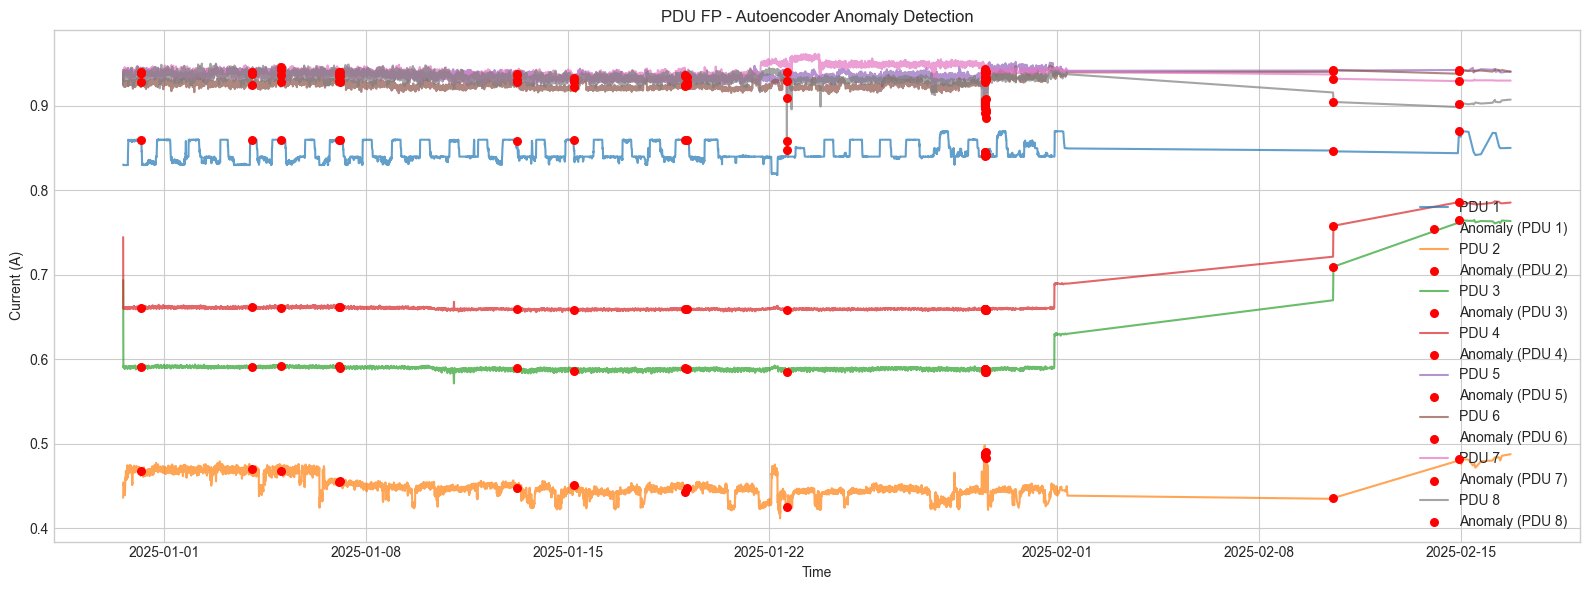

In [17]:
# PDU labels (can be renamed as needed)
pdu_labels = [f"PDU {i}" for i in range(1, 9)]

plt.figure(figsize=(16, 6))
for phase, label in zip(pdu_phases, pdu_labels):
    plt.plot(df_test_win.index, df_test_win[f"{phase}_mean"], label=label, alpha=0.7)
    plt.scatter(
        df_test_win.index[df_test_win['predicted_label_ae'] == 1],
        df_test_win.loc[df_test_win['predicted_label_ae'] == 1, f"{phase}_mean"],
        color='red', s=30, zorder=10, label=f'Anomaly ({label})'
    )

plt.title("PDU FP - Autoencoder Anomaly Detection")
plt.xlabel("Time")
plt.ylabel("Current (A)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.LSTM

#### Scaling & Reshaping

In [18]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

# Scale (LSTM prefers MinMaxScaler)
scaler_lstm = MinMaxScaler()
X_train_scaled_lstm = scaler_lstm.fit_transform(X_train_win)
X_test_scaled_lstm = scaler_lstm.transform(X_test_win)

In [19]:
# Reshape for LSTM
n_features = 8 
sequence_length = window_size
X_train_seq = X_train_scaled_lstm.reshape(-1, sequence_length, n_features)
X_test_seq = X_test_scaled_lstm.reshape(-1, sequence_length, n_features)

#### Model Def & Training

In [20]:
# Build LSTM autoencoder
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, n_features), return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])
model_lstm.compile(optimizer='adam', loss='mse')

/Users/antotim/.pyenv/versions/power_ai_clean/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("models/best_model_lstm_pdu_fp.h5", monitor='val_loss', save_best_only=True)

history_lstm = model_lstm.fit(
    X_train_seq, X_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/50
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0796

241/241 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 0.0791 - val_loss: 0.0241
Epoch 2/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0157

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0157 - val_loss: 0.0199
Epoch 3/50
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0119

241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0119 - val_loss: 0.0178
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0092

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0092 - val_loss: 0.0134
Epoch 5/50
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0077

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0077 - val_loss: 0.0129
Epoch 6/50
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0066

241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0066 - val_loss: 0.0108
Epoch 7/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0060

241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0060 - val_loss: 0.0100
Epoch 8/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0058

241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0058 - val_loss: 0.0082
Epoch 9/50
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0054

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0054 - val_loss: 0.0073
Epoch 10/50
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0051

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0051 - val_loss: 0.0069
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0050 - val_loss: 0.0070
Epoch 12/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0048

241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0048 - val_loss: 0.0068
Epoch 13/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0047

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0047 - val_loss: 0.0061
Epoch 14/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0046

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0046 - val_loss: 0.0061
Epoch 15/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0045 - val_loss: 0.0061
Epoch 16/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0045

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 17/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0043

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 18/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0042 - val_loss: 0.0125
Epoch 19/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0043

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 20/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0042

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 21/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0041

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 22/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0040

241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 23/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0040

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 24/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0039

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 25/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 26/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 27/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0037 - val_loss: 0.0047
Epoch 28/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 29/50
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0038

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 30/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0037

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 31/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 32/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 33/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 34/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 35/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0035

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 36/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 37/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 38/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0035

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 39/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 40/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 41/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 42/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 43/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 44/50
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0033

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 45/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 46/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 47/50
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0033

241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 48/50
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0033

241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 49/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 50/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0033 - val_loss: 0.0035


#### Anomaly Detection

In [22]:
# Predict and detect anomalies
X_test_pred = model_lstm.predict(X_test_seq)
reconstruction_error_lstm = np.mean(np.square(X_test_pred - X_test_seq), axis=(1, 2))
threshold_lstm = np.percentile(reconstruction_error_lstm, 99.75)
anomalies_lstm = reconstruction_error_lstm > threshold_lstm

df_test_win['reconstruction_error_lstm'] = reconstruction_error_lstm
df_test_win['predicted_label_lstm'] = anomalies_lstm.astype(int)

260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


#### Plot Results

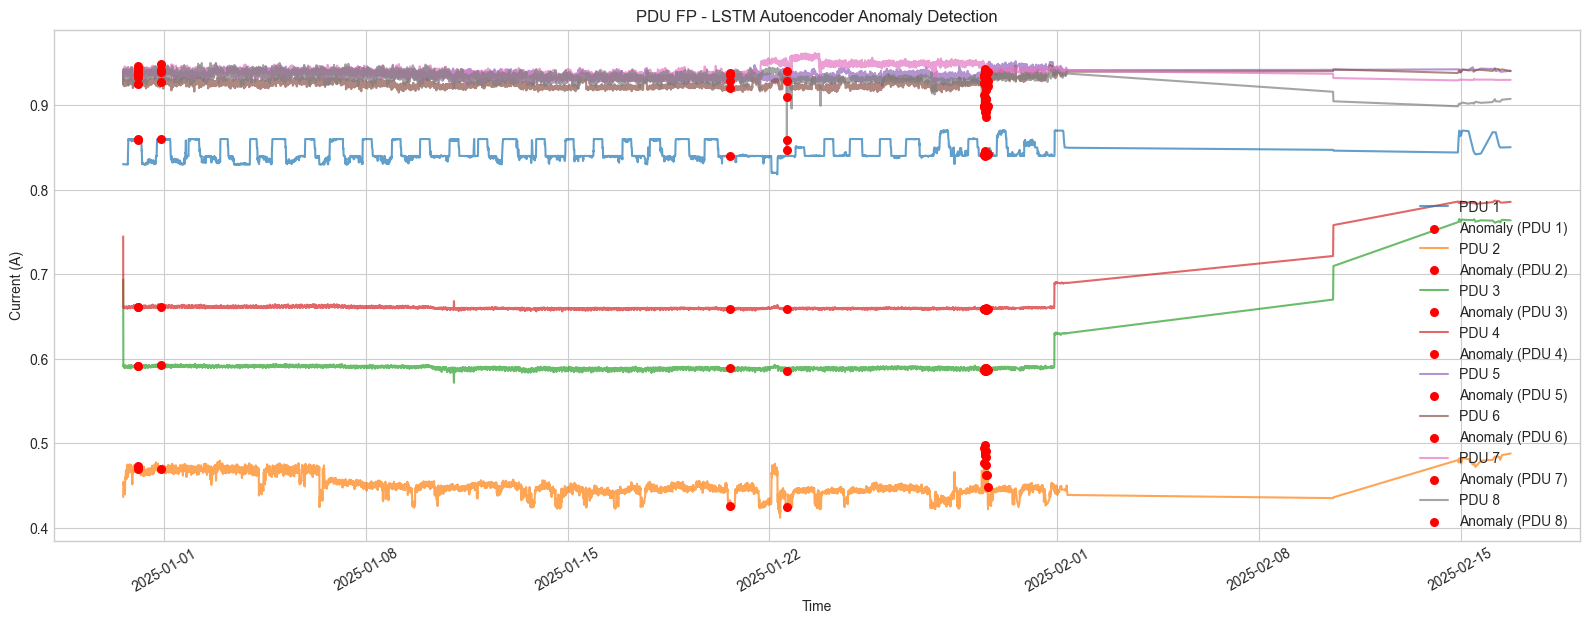

In [23]:
plt.figure(figsize=(16, 6))
for phase, label in zip(pdu_phases, pdu_labels):
    plt.plot(df_test_win.index, df_test_win[f"{phase}_mean"], label=label, alpha=0.7)
    plt.scatter(
        df_test_win.index[df_test_win['predicted_label_lstm'] == 1],
        df_test_win.loc[df_test_win['predicted_label_lstm'] == 1, f"{phase}_mean"],
        color='red', s=30, zorder=10, label=f'Anomaly ({label})'
    )

plt.title("PDU FP - LSTM Autoencoder Anomaly Detection")
plt.xlabel("Time")
plt.ylabel("Current (A)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

#### Comparing with supervisor's anomalies

In [24]:
# Supervisor's anomaly intervals (replace with actual intervals)
supervisor_anomalies = [
    (pd.Timestamp('2025-01-04 06:40'), pd.Timestamp('2025-01-04 06:42')),
    (pd.Timestamp('2025-01-04 10:33'), pd.Timestamp('2025-01-04 10:35')),
    (pd.Timestamp('2025-02-10 13:39'), pd.Timestamp('2025-02-10 13:41')),
    (pd.Timestamp('2025-02-14 19:21'), pd.Timestamp('2025-02-14 19:23')),
    (pd.Timestamp('2025-02-14 21:30'), pd.Timestamp('2025-02-14 21:33'))
]

def is_true_positive(ts, intervals, tolerance=pd.Timedelta('2min')):
    return any(start - tolerance <= ts <= end + tolerance for start, end in intervals)

def compare_anomalies(detected_indices, intervals, tolerance=pd.Timedelta('2min')):
    true_positives = [ts for ts in detected_indices if is_true_positive(ts, intervals, tolerance)]
    false_positives = [ts for ts in detected_indices if not is_true_positive(ts, intervals, tolerance)]
    false_negatives = [interval for interval in intervals if not any(is_true_positive(ts, [interval], tolerance) for ts in detected_indices)]
    return true_positives, false_positives, false_negatives

# Autoencoder
detected_ae = df_test_win.index[df_test_win['predicted_label_ae'] == 1]
tp_ae, fp_ae, fn_ae = compare_anomalies(detected_ae, supervisor_anomalies, tolerance=pd.Timedelta('2min'))

# LSTM
detected_lstm = df_test_win.index[df_test_win['predicted_label_lstm'] == 1]
tp_lstm, fp_lstm, fn_lstm = compare_anomalies(detected_lstm, supervisor_anomalies)

print("Autoencoder:")
print(f"  Total detected: {len(detected_ae)}")
print(f"  True positives: {len(tp_ae)}")
print(f"  False positives: {len(fp_ae)}")
print(f"  False negatives: {len(fn_ae)}")

print("LSTM:")
print(f"  Total detected: {len(detected_lstm)}")
print(f"  True positives: {len(tp_lstm)}")
print(f"  False positives: {len(fp_lstm)}")
print(f"  False negatives: {len(fn_lstm)}")

Autoencoder:
  Total detected: 21
  True positives: 0
  False positives: 21
  False negatives: 5
LSTM:
  Total detected: 21
  True positives: 0
  False positives: 21
  False negatives: 5


#### Summary Table

In [25]:
summary = pd.DataFrame({
    "Model": ["Autoencoder", "LSTM"],
    "Window Size": [window_size, window_size],
    "Total Detected": [len(detected_ae), len(detected_lstm)],
    "True Positives": [len(tp_ae), len(tp_lstm)],
    "False Positives": [len(fp_ae), len(fp_lstm)],
    "False Negatives": [len(fn_ae), len(fn_lstm)],
})

In [26]:
summary

,Model,Window Size,Total Detected,True Positives,False Positives,False Negatives
0,Autoencoder,32,21,0,21,5
1,LSTM,32,21,0,21,5


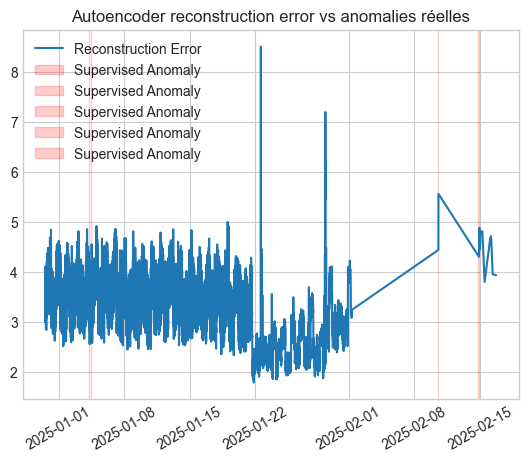

In [27]:
plt.plot(df_test_win.index, df_test_win['reconstruction_error_ae'], label="Reconstruction Error")
for start, end in supervisor_anomalies:
    plt.axvspan(start, end, color='red', alpha=0.2, label='Supervised Anomaly')
plt.legend()
plt.title("Autoencoder reconstruction error vs anomalies réelles")
plt.xticks(rotation=30)
plt.show()